## Sparse Mapping of the Second Earth

### -Three main libraries  
**tsv_healpix:** Solver using sparse modeling  (l1-norm + TSV)  
https://web.iem.technion.ac.il/images/user-files/becka/papers/27.pdf  
https://people.rennes.inria.fr/Cedric.Herzet/Cedric.Herzet/Sparse_Seminar/Entrees/2012/11/12_A_Fast_Iterative_Shrinkage-Thresholding_Algorithmfor_Linear_Inverse_Problems_(A._Beck,_M._Teboulle)_files/Breck_2009.pdf  


**tikhonov_solve:** Solver using Tikhonov regularization (l2-norm)  
https://arxiv.org/abs/1204.3504  
https://en.wikipedia.org/wiki/Tikhonov_regularization

**geometry:** Calculating "Transfer Matrix" and related vectors for reflection light  
https://arxiv.org/abs/1204.3504

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import healpy as hp
import pylab 
import matplotlib.pyplot as plt
import time
from tsv_healpix import *
from tikhonov_solve import *
from geometry import *

## Prepring Folders

##Sructure of Folders##
    
- result
    - branch
        - model: output model saved as "*.npy" (numpy data)
            - cv: models saved in CV process
        - others: cv_result, light_curve, ....
        - figure_map: model figures (albedo map)
        
Change "folder_branch" if you make new independent folder



In [2]:
folder_root_result = "./result/" 
folder_branch = "sample_result/"

if not os.path.isdir(folder_root_result):
    os.mkdir(folder_root_result)

folder_out = folder_root_result + folder_branch
if not os.path.isdir(folder_out):
    os.mkdir(folder_out)

folder_model = folder_out + "model/"
if not os.path.isdir(folder_model):
    os.mkdir(folder_model)

folder_model_cv = folder_out + "model/cv/" 
if not os.path.isdir(folder_model_cv):
    os.mkdir(folder_model_cv)

folder_others = folder_out + "others/" 
if not os.path.isdir(folder_others):
    os.mkdir(folder_others)

folder_fig = folder_out + "figure_map/" 
if not os.path.isdir(folder_fig):
    os.mkdir(folder_fig)

## Loading & Showing Map 

""""  
data: mockalbedo16.fits  
nside:16  
""""

Figure is saved in "figure_map" folder


NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


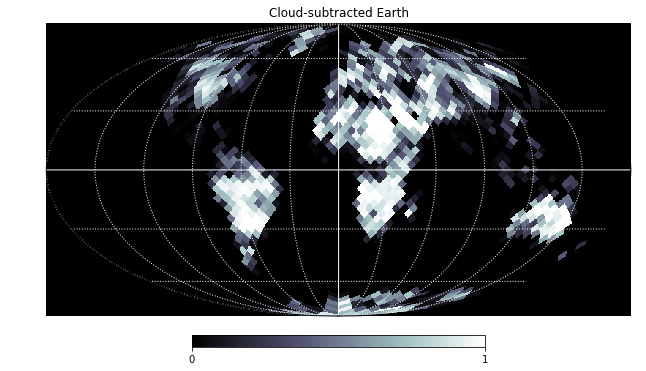

In [3]:
# test map

file_data = "data/mockalbedo16.fits"
nside=16
mmap=hp.read_map(file_data)
hp.mollview(mmap, title="Cloud-subtracted Earth",flip="geo",cmap=plt.cm.bone,min=0,max=1)
hp.graticule(color="white");
plt.savefig(folder_fig + "answer.pdf", dpi=200, bbox_inches="tight")
M=len(mmap)

## Setting geometry parameters

See https://arxiv.org/abs/1204.3504 in detail

In [42]:
inc=np.pi/6.0
Thetaeq=np.pi
zeta=np.pi/2.0                                                                                               
Pspin=23.9344699/24.0                                                                                                                                                                                                           
wspin=2*np.pi/Pspin                                                                                                          
Porb=365.242190402                                            
worb=2*np.pi/Porb                                                                                                                
N=1024
s_n = 20
obst=np.linspace(0.0,Porb,N)

### Calculation of Kernel Function & Light Curve

In [43]:
### Calculation of Kernel Function & Light Curve
Thetav=worb*obst
Phiv=np.mod(wspin*obst,2*np.pi)
WI,WV=comp_weight(nside,zeta,inc,Thetaeq,Thetav,Phiv)
W=WV[:,:]*WI[:,:]
lc_original=np.dot(W,mmap)
lc_mean = np.mean(lc_original)
normalize_lc = (s_n**2)/lc_mean
lc = np.random.poisson(lc_original * normalize_lc)/normalize_lc
sigma_arr = np.sqrt(lc_original * normalize_lc)/normalize_lc

Theta_lc = np.array([Thetav,lc])
np.save(folder_others + "light_theta", Theta_lc)



In [44]:
sys.stdout.flush()
print(len(lc))

1024


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


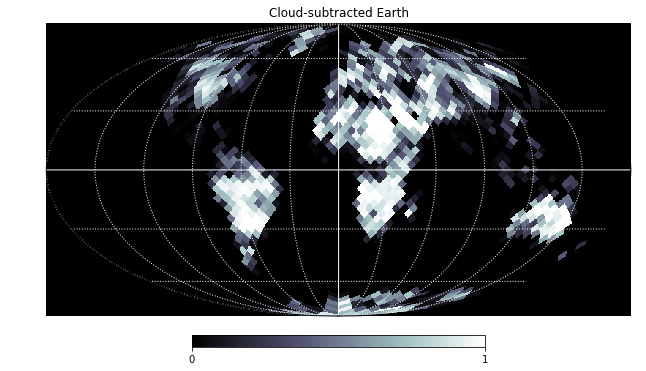

In [45]:
hp.mollview(mmap, title="Cloud-subtracted Earth",flip="geo",cmap=plt.cm.bone,min=0,max=1)
hp.graticule(color="white");
plt.savefig(folder_fig + "answer.pdf", dpi=200, bbox_inches="tight")
M=len(mmap)

In [46]:
sys.stdout.flush()
print (np.shape(W))
print (np.shape(np.mean(W, axis =0)))

(1024, 3072)
(3072,)


In [47]:
print (np.min(W_mean))
print (np.sum(W_mean))

0.0
173.50781798657874


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


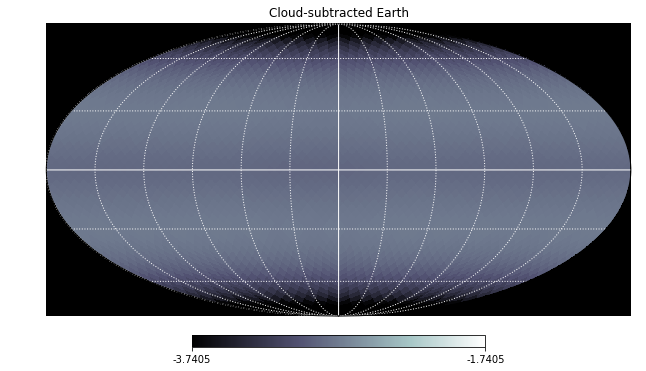

In [48]:
W_mean = np.mean(W,axis = 0)
hp.mollview(np.log(W_mean), title="Cloud-subtracted Earth",flip="geo",cmap=plt.cm.bone,min=0,max=np.max(np.log(W_mean)))
hp.graticule(color="white");
plt.savefig(folder_fig + "answer.pdf", dpi=200, bbox_inches="tight")
plt.show()


## Sparse mapping
"mfista_func_healpix" is the main function with varying ( lambda_l1,lambda_tsv).  
We adopt (lambda_l1, lambda_tsv) = $(10^{-1}, 10^{0})$, which gave the optimal solution in the last CV run (use cv_run.py for that)

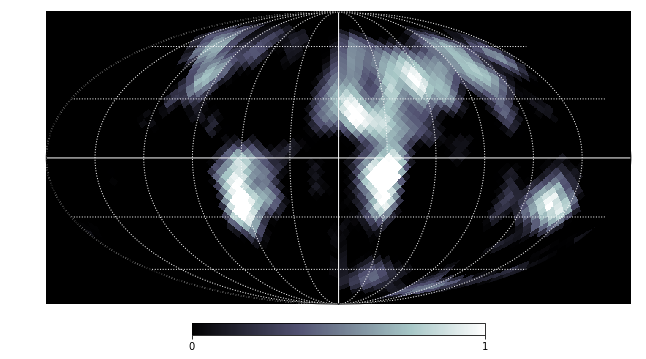

In [50]:
import io
import sys
I_init = np.zeros(len(mmap)) + np.mean(lc)
lambda_tsv = 10**-1
lambda_l1 = 10**0 ## Too large lambda_l1 might fail to solve equations
L_init= lambda_l1 *1

weight_matrix, test = calc_neighbor_weightmatrix(hp, nside)
I_est = mfista_func_healpix(I_init, lc, W, weight =weight_matrix, L_init = L_init, sigma =sigma_arr, eta = 1.3, lambda_l1 =lambda_l1 , lambda_tsv = lambda_tsv , maxiter=10000)
output = io.StringIO()
np.save(folder_model + "best_model", I_est)
sys.stdout = output
hp.mollview(I_est , title="",flip="geo",cmap=plt.cm.bone,min=0,max=1.0)
hp.graticule(color="white")
plt.savefig(folder_fig + "l1_tsv_best.pdf", dpi = 200)
sys.stdout = sys.__stdout__


## Mapping with Tikhonov regularization 
Solve mapping problem with l2-norm using "lcurve"

In [ ]:
## Kawahara san's method
tikhonov_result_out(W, lc, M, folder_name = folder_out)